In [1]:
import warnings

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
import matplotlib.colors as mcolors
#import matplotlib.colors

import math as math

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.ticker as mticker
import pandas as pd
from matplotlib import gridspec

import numpy.ma as ma

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

Read in the model data files

In [2]:
datadir='/shared/CAREER_PWC/DeepMIP-EOT/um_grid/'
ldir=['ocean','surface']
mdir=['baatsen','huber','hutchinson','kennedy','ladant','sijp','zhang']

Compile sea surface model temperature files into an array

In [4]:
#sea surface temperature
filename=[]
for i in range(len(mdir)):
    m=datadir+ldir[0]+'/'+mdir[i]+'/'+'*'
    files=!ls {m}
    for j in range(len(files)):
        if i==0 and j==0:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            SST=ds.temp
            SST.expand_dims(dim='exp')
            filename.append(files[j])
        elif i==2:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            if i==2 and j==0:
                continue
            SST=xr.concat([SST,ds.sst], dim='exp')
            filename.append(files[j])
        elif i==3:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            if i==3 and j==4 or j==5 or j==7:
                continue
            SST=xr.concat([SST, ds.temp_ym_dpth], 'exp')
            filename.append(files[j])
        elif i==4:
            ds=xr.open_dataset(files[j],engine="netcdf4",decode_times=False)
            if i==4 and j==0 or j==2 or j==3:
                continue
            SST=xr.concat([SST, ds.TEMP], 'exp')
            filename.append(files[j])
        elif i==5:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            ds['sst']=ds['sst']-273.15 #sijp data is in kelvin
            SST=xr.concat([SST, ds.sst], 'exp')
            filename.append(files[j])
        elif i==6:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            if i==6 and j==0:
                continue
            SST=xr.concat([SST, ds.templvl], 'exp')
            filename.append(files[j])
        else:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            if i==1 and j==2 or j==4:
                continue
            if ds.temp.dims[0]=='lat' and ds.temp.dims[1]=='lon':
                ds2=ds.rename_dims({'lat':'latitude','lon':'longitude'})
                SST=xr.concat([SST, ds2.temp], dim='exp')
                filename.append(files[j])
            else:
                SST=xr.concat([SST, ds.temp], dim='exp')
                filename.append(files[j])
            
        
        




Compile surface air temperature files into an array

In [5]:
#Surface Air temperature
filename_SAT=[]
for i in range(len(mdir)):
    m=datadir+ldir[1]+'/'+mdir[i]+'/'+'*'
    files=!ls {m}
    for j in range(len(files)):
        if i==0 and j==0:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            if ds.temp.dims[0]!='latitude' and ds.temp.dims[1]!='longitude':
                    ds.temp.rename_dims({'lat':'latitude','lon':'longitude'})
            SAT=ds.temp
            filename_SAT.append(files[j])
        elif i==2:        
            ds=xr.open_dataset(files[j],engine="netcdf4")
            if i==2 and j==0:
                continue
            SAT=xr.concat([SAT,ds.t_ref], dim='exp')
            filename_SAT.append(files[j])
        elif i==3:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            if i==3 and j==4 or j==5 or j==7:
                continue
            SAT=xr.concat([SAT, ds.temp_mm_1_5m], 'exp')
            filename_SAT.append(files[j])
        elif i==4:
            ds=xr.open_dataset(files[j],engine="netcdf4",decode_times=False)
            if i==4 and j==1 or j==2 or j==3:
                continue
            SAT=xr.concat([SAT, ds.TEMP], 'exp')
            filename_SAT.append(files[j])
        elif i==5:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            SAT=xr.concat([SAT, ds.sat], 'exp')
            filename_SAT.append(files[j])
        elif i==6:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            if i==6 and j==0:
                continue
            SAT=xr.concat([SAT, ds.T], 'exp')
            filename_SAT.append(files[j])
        else:
            ds=xr.open_dataset(files[j],engine="netcdf4")
            if i==1 and j==2 or j==3 or j==4 or j==6:
                continue
            if ds.temp.dims[0]=='lat' and ds.temp.dims[1]=='lon':
                ds2=ds.rename_dims({'lat':'latitude','lon':'longitude'})
                SAT=xr.concat([SAT, ds2.temp], dim='exp')
                filename_SAT.append(files[j])
            else:
                SAT=xr.concat([SAT, ds.temp], dim='exp')
                filename_SAT.append(files[j])

Scaling the Zhang models

In [7]:
scalefact=(math.log(1120)-math.log(560))/(math.log(980)-math.log(560))

SAT[22,:,:]=SAT[23]+scalefact*(SAT[22]-SAT[23])
SST[22,:,:]=SST[23]+scalefact*(SST[22]-SST[23])


Converting surface air temperatures to celsius

In [9]:
SAT_C=SAT-273.15
SAT_C_updated=SAT_C.sortby('latitude',ascending=True)
SST_updated=SST.sortby('latitude',ascending=True)

Adding identifiers for each file to filter for comparisons

In [10]:
CO2_concx=np.array([560,1120,560,560,1120,1120,1120,400,800,800,560,560,560,1120,560,560,560,560,1120,1600,1600,560,980,560])
CO2_concx_SST=np.array(['2x','4x','','2x','','4x','','2x','4x','','','2x','','4x','','','','2x','4x','','','','4x','2x'])
CO2_concx_SAT=np.array(['2x','4x','','2x','','4x','','2x','4x','','','2x','','4x','','','2x','','4x','','','','4x','2x'])

In [11]:
#identification of each file parameter to call for plotting. SST and SAT need separate calls due to a difference file order for Ladant 
modelnames=np.array(['CESM_B','CESM_B','CESM_H','CESM_H','CESM_H','CESM_H','CESM_H','GFDL_CM2.1','GFDL_CM2.1','GFDL_CM2.1','HadCM3BL','HadCM3BL','HadCM3BL','HadCM3BL','HadCM3BL','FOAM','FOAM','FOAM','FOAM','Uvic','Uvic','NorESM-L','NorESM-L','NorESM-L'])

run_infoice_SST=np.array(['','','ice','No ice','','','','','','','ice','No ice','','','','','ice','No ice','','','','','',''])

run_infoice_SAT=np.array(['','','ice','No ice','','','','','','','ice','No ice','','','','','No ice','ice','','','','','',''])

run_infogeo_SST=np.array(['','','','','PreEOT','','PostEOT','','PreEOT','PostEOT','','','PostEOT','','PreEOT','PostEOT','','PreEOT','','PreEOT','PostEOT','PostEOT','','PreEOT'])

run_infogeo_SAT=np.array(['','','','','PreEOT','','PostEOT','','PreEOT','PostEOT','','','PostEOT','','PreEOT','PostEOT','PreEOT','','','PreEOT','PostEOT','PostEOT','','PreEOT'])

Read in the proxy temperature anomalies both SST and SAT

In [12]:
EOT_proxy_SST=pd.read_csv('/homes/etibbett/EOT_data_share/EOT_temperaturecomparison_python_4.11.csv',header=0,usecols=['Paleolatitude','Paleolongitude','Oligo SST','Eocene SST'])
EOT_proxy_SAT=pd.read_csv('/homes/etibbett/EOT_data_share/EOT_temperaturecomparison_python_4.11.csv',header=0,usecols=['Paleolatitude','Paleolongitude','Oligo SAT','Eocene SAT'])


EOT_proxydiff_SST=EOT_proxy_SST['Oligo SST']-EOT_proxy_SST['Eocene SST']
EOT_proxydiff_SAT=EOT_proxy_SAT['Oligo SAT']-EOT_proxy_SAT['Eocene SAT']

proxydiff_SST=EOT_proxydiff_SST

SST_proxydiff=proxydiff_SST.to_xarray()
proxydiff_SAT=EOT_proxydiff_SAT.dropna()
SAT_proxydiff=proxydiff_SAT.to_xarray()

SAT_proxy=EOT_proxy_SAT.dropna()
proxy_SAT=SAT_proxy.to_xarray()

SST_proxy=EOT_proxy_SST.dropna()
proxy_SST=SST_proxy.to_xarray()

EOT_proxy_SAT['EOT diff']=EOT_proxy_SAT['Oligo SAT']-EOT_proxy_SAT['Eocene SAT']
EOT_proxy_SST['EOT diff']=EOT_proxy_SST['Oligo SST']-EOT_proxy_SST['Eocene SST']


In [13]:
#isolating only 2x runs


CO2_concx2=np.where(CO2_concx_SAT=='2x')
CO2_concls_2x=np.array(CO2_concx2)
SAT_conc2x=SAT_C_updated[CO2_concls_2x[0,:],:,:]

model_high=modelnames[CO2_concls_2x[0,:]]
conc_2x=CO2_concx[CO2_concls_2x[0,:]]

CO2_concx2_SST=np.where(CO2_concx_SST=='2x')
CO2_concls_2x_SST=np.array(CO2_concx2_SST)
SST_conc2x=SST_updated[CO2_concls_2x_SST[0,:],:,:]
landmask_2x=np.isnan(SST_conc2x)

#isolating only 4x runs


CO2_concx4_SAT=np.where(CO2_concx_SAT=='4x')
CO2_concls_4x=np.array(CO2_concx4_SAT)
SAT_conc4x=SAT_C_updated[CO2_concls_4x[0,:],:,:]

model_high=modelnames[CO2_concls_4x[0,:]]
conc_high=CO2_concx[CO2_concls_4x[0,:]]

CO2_concx4_SST=np.where(CO2_concx_SST=='4x')
CO2_concls_4x_SST=np.array(CO2_concx4_SST)
SST_conc4x=SST[CO2_concls_4x_SST[0,:],:,:]
landmask_4x=np.isnan(SST_conc4x)

#difference plots for CO2 temperature

diffconcx=SAT_conc2x-SAT_conc4x

diffconc_C_polar=diffconcx.where(diffconcx.latitude<=-30)

SST_diffconcx=SST_conc2x-SST_conc4x



Calculate and add the model ensemble mean

In [14]:
#model ensemble mean

ensemblemean=np.mean(diffconcx, axis=0)
ensemblemean_SST=np.mean(SST_diffconcx,axis=0)
diff_modelconc=xr.concat([diffconcx,ensemblemean],'exp')
diff_modelconc_SST=xr.concat([SST_diffconcx,ensemblemean_SST],'exp')

landmaskmean=np.mean(landmask_2x)
landmask=xr.concat([landmask_2x,landmaskmean],'exp')

#Eocene mean
ensemblemean_eo_SST=np.mean(SST_conc4x, axis=0)
SSTmodel_EO=xr.concat([SST_conc4x,ensemblemean_eo_SST],'exp')
ensemblemean_eo=np.mean(SAT_conc4x, axis=0)
SATmodel_EO=xr.concat([SAT_conc4x,ensemblemean_eo],'exp')
landmask_4xmean=np.mean(landmask_4x)
landmask_4x=xr.concat([landmask_4x,landmask_4xmean],'exp')

#Oligocene mean
ensemblemean_oligo=np.mean(SAT_conc2x, axis=0)
SATmodel_Oligo=xr.concat([SAT_conc2x,ensemblemean_oligo],'exp')
ensemblemean_oligo_SST=np.mean(SST_conc2x, axis=0)
SSTmodel_Oligo=xr.concat([SST_conc2x,ensemblemean_oligo_SST],'exp')

Create separate datafiles for each model for the proxy input to adjust paleocoordinates and model averaging

In [15]:
proxy_SAT=EOT_proxy_SAT.dropna().reset_index(drop=True)
proxy_SAT_0=proxy_SAT[:]
proxy_SAT_1=proxy_SAT[:]
proxy_SAT_2=proxy_SAT[:]
proxy_SAT_3=proxy_SAT[:]
proxy_SAT_4=proxy_SAT[:]
proxy_SAT_5=proxy_SAT[:]
proxy_SAT_6=proxy_SAT[:]

In [16]:
#1st model
proxy_SAT_0['New paleolat']=proxy_SAT_0['Paleolatitude']
proxy_SAT_0['New paleolon']=proxy_SAT_0['Paleolongitude']

latchange=[-7,-7,0,5,-10,-3]
lonchange=[5,5,-10,0,-18,-12]
for i in range(0,6):
        proxy_SAT_0['New paleolat'][i]=proxy_SAT_0['Paleolatitude'][i]+latchange[i]
        proxy_SAT_0['New paleolon'][i]=proxy_SAT_0['Paleolongitude'][i]+lonchange[i]

#2nd model
proxy_SAT_1['New paleolat']=proxy_SAT_1['Paleolatitude']
proxy_SAT_1['New paleolon']=proxy_SAT_1['Paleolongitude']

latchange=[-12,-12,0,-3,-5,-11]
lonchange=[0,0,0,2.5,-18,-10]
for i in range(0,6):
        proxy_SAT_1['New paleolat'][i]=proxy_SAT_1['Paleolatitude'][i]+latchange[i]
        proxy_SAT_1['New paleolon'][i]=proxy_SAT_1['Paleolongitude'][i]+lonchange[i]

#3rd model        
proxy_SAT_2['New paleolat']=proxy_SAT_2['Paleolatitude']
proxy_SAT_2['New paleolon']=proxy_SAT_2['Paleolongitude']
latchange=[-8,-8,0,5,-5,-3]
lonchange=[15,15,0,2,-15,-10]
for i in range(0,6):
        proxy_SAT_2['New paleolat'][i]=proxy_SAT_2['Paleolatitude'][i]+latchange[i]
        proxy_SAT_2['New paleolon'][i]=proxy_SAT_2['Paleolongitude'][i]+lonchange[i]

#4th model        
proxy_SAT_3['New paleolat']=proxy_SAT_3['Paleolatitude']
proxy_SAT_3['New paleolon']=proxy_SAT_3['Paleolongitude']        
latchange=[-5,-5,0,0,-2,-8]
lonchange=[0,0,0,0,-13,-12]
for i in range(0,6):
        proxy_SAT_3['New paleolat'][i]=proxy_SAT_3['Paleolatitude'][i]+latchange[i]
        proxy_SAT_3['New paleolon'][i]=proxy_SAT_3['Paleolongitude'][i]+lonchange[i]
        
#5th model        
proxy_SAT_4['New paleolat']=proxy_SAT_4['Paleolatitude']
proxy_SAT_4['New paleolon']=proxy_SAT_4['Paleolongitude']        
latchange=[-7,-7,0,0,-5,-8]
lonchange=[0,0,0,-2,-15,-14]
for i in range(0,6):
        proxy_SAT_4['New paleolat'][i]=proxy_SAT_4['Paleolatitude'][i]+latchange[i]
        proxy_SAT_4['New paleolon'][i]=proxy_SAT_4['Paleolongitude'][i]+lonchange[i]
        
#6th model        
proxy_SAT_5['New paleolat']=proxy_SAT_5['Paleolatitude']
proxy_SAT_5['New paleolon']=proxy_SAT_5['Paleolongitude']        
latchange=[-6,-6,0,0,-5,-8]
lonchange=[0,0,0,0,-13,-12]
for i in range(0,6):
        proxy_SAT_5['New paleolat'][i]=proxy_SAT_5['Paleolatitude'][i]+latchange[i]
        proxy_SAT_5['New paleolon'][i]=proxy_SAT_5['Paleolongitude'][i]+lonchange[i]
        
#7th model ensemble average       
proxy_SAT_6['New paleolat']=proxy_SAT_6['Paleolatitude']
proxy_SAT_6['New paleolon']=proxy_SAT_6['Paleolongitude']        
latchange=[-5,-5,0,0,-5,-8]
lonchange=[0,0,0,0,-16,-12]
for i in range(0,6):
        proxy_SAT_6['New paleolat'][i]=proxy_SAT_6['Paleolatitude'][i]+latchange[i]
        proxy_SAT_6['New paleolon'][i]=proxy_SAT_6['Paleolongitude'][i]+lonchange[i]

/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [18]:
proxy_SAT_0=proxy_SAT_0.to_xarray()
proxy_SAT_1=proxy_SAT_1.to_xarray()
proxy_SAT_2=proxy_SAT_2.to_xarray()
proxy_SAT_3=proxy_SAT_3.to_xarray()
proxy_SAT_4=proxy_SAT_4.to_xarray()
proxy_SAT_5=proxy_SAT_5.to_xarray()
proxy_SAT_6=proxy_SAT_6.to_xarray()

SAT_proxy=proxy_SAT_0.expand_dims(dim='nmodels')
SAT_proxy=xr.concat([SAT_proxy,proxy_SAT_1],'nmodels')
SAT_proxy=xr.concat([SAT_proxy,proxy_SAT_2],'nmodels')
SAT_proxy=xr.concat([SAT_proxy,proxy_SAT_3],'nmodels')
SAT_proxy=xr.concat([SAT_proxy,proxy_SAT_4],'nmodels')
SAT_proxy=xr.concat([SAT_proxy,proxy_SAT_5],'nmodels')
SAT_proxy=xr.concat([SAT_proxy,proxy_SAT_6],'nmodels')

In [19]:
#Adjust for sites that differ due to vriations in paleoreconstruction
proxy_SAT['Paleolongitude'][0]=69
proxy_SAT['Paleolongitude'][2]=150


For SAT isolate source areas on land for temperature comparison to records from ocean drilling cores

In [20]:
datlist=list([0,1,2,3,4,5])
lats=range(0,73)
lons=range(0,96)
circles=[] #
lat=diff_modelconc.latitude
lon=diff_modelconc.longitude
circles=np.empty([6,7,73,96])
circles=xr.DataArray(circles,dims=['nproxies','nmodels','latitude','longitude'])
#circles=xr.DataArray(array,dims=['nproxies','nmodels'])

#this finds circular areas on land within X km of a point
for j in range(0,len(diff_modelconc)):
    for i in (datlist):
        arr=np.zeros((len(lats),len(lons))) #domain of zeroes
        originlat=SAT_proxy['New paleolat'][j][datlist][i] #circle center lat
        originlon=SAT_proxy['New paleolon'][j][datlist][i]
        if i==0 or i==1: #same cores different proxies
            if j==0:
                masklon = abs(diff_modelconc[j].longitude[lons]- originlon)<17
                masklat = abs(diff_modelconc[j].latitude[lats]-originlat)<10
                arr[masklat & masklon] = 1
            if j==1:
                masklon = abs(diff_modelconc[j].longitude[lons]- originlon)<20
                masklat = abs(diff_modelconc[j].latitude[lats]-originlat)<7
                arr[masklat & masklon] = 1
            if j==2:
                masklon = abs(diff_modelconc[j].longitude[lons]- originlon)<20
                masklat = abs(diff_modelconc[j].latitude[lats]-originlat)<8
                arr[masklat & masklon] = 1
            if j==3 or j==4 or j==5 or j==6:
                masklon = abs(diff_modelconc[j].longitude[lons]- originlon)<15
                masklat = abs(diff_modelconc[j].latitude[lats]-originlat)<10
                arr[masklat & masklon] = 1
        if i==2:
            masklon = (diff_modelconc[j].longitude[lons]- originlon)<17
            masklonl= (diff_modelconc[j].longitude[lons]- originlon)>-40
            masklat = (diff_modelconc[j].latitude[lats]-originlat)<8
            masklatl = (diff_modelconc[j].latitude[lats]-originlat)>-6
            arr[masklat & masklatl & masklon & masklonl] = 1
        if i==4:
            masklon = abs(diff_modelconc[j].longitude[lons]- originlon)<6
            masklat = abs(diff_modelconc[j].latitude[lats]-originlat)<5
            arr[masklat & masklon] = 1
        if i==3 or i==5:
            if j==0 or j==2 or j==3 or j==4 or j==5 or j==6:
                masklon = abs(diff_modelconc[j].longitude[lons]- originlon)<5.5
                masklat = abs(diff_modelconc[j].latitude[lats]-originlat)<4
                arr[masklat & masklon] = 1
            if j==1:
                masklon = abs(diff_modelconc[j].longitude[lons]- originlon)<7
                masklat = abs(diff_modelconc[j].latitude[lats]-originlat)<4
                arr[masklat & masklon] = 1
        arr = np.where(diff_modelconc[j][lats,lons]!='nan',arr,0) #how to do this for the SAT when there are no isnan
        arr = np.where(arr==0,np.nan,1)
        #circles.append(arr)
        #arr.append([])
        circles[i,j,:,:]=arr; del arr 
        #circles[i,4].append(arr)

In [21]:
datlist=list([0,1,2,3,4,5])
array=np.empty((6,7,73,96))
mean_SAT=xr.DataArray(array,dims=['nproxies','nmodels','latitude','longitude'])
prox=np.empty((6))
for ex in range(0,len(diff_modelconc)):
    for i in range(0, len(datlist)):
        modelmean= diff_modelconc[ex,:,:]
        mean_SAT[i,ex,:,:]=np.where(circles[i,ex,:,:]==1, modelmean, np.nan)
        prox[i] = proxy_SAT['EOT diff'][datlist][i]
        
mean_SAT['latitude']=diff_modelconc.latitude
mean_SAT['longitude']=diff_modelconc.longitude
   
weights=np.cos(np.deg2rad(diff_modelconc.latitude))
SAT_weighted=mean_SAT.weighted(weights)
weighted_SAT = SAT_weighted.mean(dim=("longitude","latitude"))

errors=np.empty((6,7))
rms_diffSAT=np.empty((7))
for ex in range(0,len(diff_modelconc)):
        errors[:,ex]=(weighted_SAT[:,ex]-prox[:])
        rms_diffSAT[ex]=np.sqrt(sum(pow(errors[:,ex],2)) / len(datlist)).round(decimals=1) 
rms_diffSAT

array([3. , 2.9, 5. , 1.7, 3.2, 1.9, 2.7])

Sea Surface Temperatures-Using nearest point

In [22]:
EOT_proxy_SST['New paleolat']=EOT_proxy_SST['Paleolatitude']
EOT_proxy_SST['New paleolon']=EOT_proxy_SST['Paleolongitude']

In [23]:

avg511_dict = {'Paleolatitude':[-53.96],
        'Paleolongitude':[323.80],
        'Oligo SST':[10.8],
        'Eocene SST':[17.9],
        'EOT diff':[-7.1],
        'New paleolat':[-53.96],
        'New paleolon':[323.80]}
        
avg511_df1 = pd.DataFrame(avg511_dict)    
avg=[-53.96,323.80,10.8,17.9,-7.1,-53.96,323.80]

In [24]:
EOT_proxy_SST = pd.concat([EOT_proxy_SST, avg511_df1], ignore_index = True)

In [25]:
EOT_proxy_SST=EOT_proxy_SST.drop([10]).reset_index(drop=True)
EOT_proxy_SST=EOT_proxy_SST.drop([9]).reset_index(drop=True)

In [26]:
latchange=[5,5,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0]
lonchange=[0,0,0,5,0,0,0,0,0,0,0,5,0,15,15,0,0,0,0,0,0,0,0,0,0]
for i in range(0,25):
    EOT_proxy_SST['New paleolat'][i]=EOT_proxy_SST['Paleolatitude'][i]+latchange[i]
    EOT_proxy_SST['New paleolon'][i]=EOT_proxy_SST['Paleolongitude'][i]+lonchange[i]
    

In [27]:
Eocene_proxy_SST = EOT_proxy_SST[EOT_proxy_SST['Eocene SST'].notnull()].reset_index(drop=True)
Oligo_proxy_SST = EOT_proxy_SST[EOT_proxy_SST['Oligo SST'].notnull()].reset_index(drop=True)
proxy_SST = EOT_proxy_SST[EOT_proxy_SST['EOT diff'].notnull()].reset_index(drop=True)

In [28]:
#difference
diffmodel_SST=np.empty((9,7))
prox=np.empty((9))
for i in range(0,len(proxy_SST)):
    for j in range (0,len(diff_modelconc_SST)):
        diffmodel_SST[i,j]=(diff_modelconc_SST[j].sel(latitude=proxy_SST['New paleolat'][i],longitude=proxy_SST['New paleolon'][i],method='nearest'))
        prox[i] = proxy_SST['EOT diff'][i]

errors=np.empty((9,7))
rms_diffSST=np.empty((7))
for ex in range(0,len(diff_modelconc_SST)):
    errors[:,ex]=(diffmodel_SST[:,ex]-prox[:])
    rms_diffSST[ex]=np.sqrt(sum(pow(errors[:,ex],2)) / len(proxy_SST)).round(decimals=1)
rms_diffSST

array([2.4, 2.2, 4. , 1.9, 2.9, 2. , 2.3])

In [29]:
#offsetting points to plot data from same cores (Eocene)
Eocene_proxy_SST['New paleolon'][4]=318
Eocene_proxy_SST['New paleolon'][5]=185
Eocene_proxy_SST['New paleolon'][9]=306


In [30]:
#offsetting points to plot data from same cores (Oligocene)
Oligo_proxy_SST['New paleolon'][3]=352
Oligo_proxy_SST['New paleolon'][5]=185
Oligo_proxy_SST['New paleolon'][4]=318


In [31]:
#offsetting points to plot data from same cores (Difference)
proxy_SST['New paleolon'][3]=352
proxy_SST['New paleolon'][4]=317
proxy_SST['New paleolon'][5]=185


Estimating pCO2 drop using the same n proxy locations but using the model temperatures as truths

In [33]:
#create testarray for scaling
nxx=101
testarray=np.linspace(0,2,nxx)

In [34]:
def SKILL(my_mod,my_dat,ncols):
    ans=math.sqrt(sum((my_mod-my_dat)*(my_mod-my_dat))/(1.0*ncols)) #ncols corresponds to the proxy data RMSE
    return ans

In [35]:
array=np.empty((101,6,7))
vect=xr.DataArray(array,dims=['nxx','nproxies','nmodels'])
for j in range (0,len(testarray)):
    for i in range (0,len(weighted_SAT)):
        vect[j,i,:]=testarray[j]*weighted_SAT[i,:] #weighted_SAT is the model closest values to proxy locations

array_SST=np.empty((101,9,7))
vect_SST=xr.DataArray(array_SST,dims=['nxx','nproxies','nmodels'])
for j in range (0,len(testarray)):
    for i in range (0,len(diffmodel_SST)):
        vect_SST[j,i,:]=testarray[j]*diffmodel_SST[i,:] #diffmodel_SST is the SST model closest values to proxy location

Calculate RMSE

In [36]:
#SST
errs_1d_SST=np.empty((101,7,7))
nanmatrix=np.empty((101,7))*np.nan
for j in range(0,len(vect_SST.nmodels)):
    for i in range(0,len(vect_SST.nxx)):
        for h in range(0,len(vect_SST.nmodels)):
            if j==h:
                errs_1d_SST[i,j,h]=nanmatrix[i,j]
            else:
                errs_1d_SST[i,j,h]=SKILL(vect_SST[i,:,j],diffmodel_SST[:,h],9)
inval_1d_SST=np.min(errs_1d_SST,axis=0)
ind_1d_SST=np.argmin(errs_1d_SST,axis=0)

In [37]:
#SAT
errs_1d=np.empty((101,7,7))
nanmatrix=np.empty((101,7))*np.nan
for j in range(0,len(vect.nmodels)):
    for i in range(0,len(vect.nxx)):
        for h in range(0,len(vect.nmodels)):
            if j==h:
                errs_1d[i,j,h]=nanmatrix[i,j]
            else:
                errs_1d[i,j,h]=SKILL(vect[i,:,j],weighted_SAT[:,h],6) 
                
inval_1d=np.min(errs_1d,axis=0)
ind_1d=np.argmin(errs_1d,axis=0)

/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


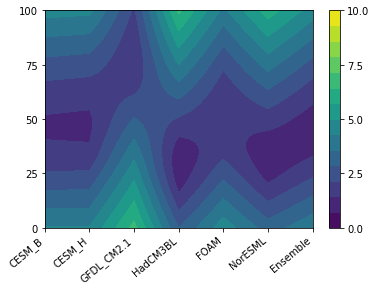

In [38]:
#SAT
fig, ax = plt.subplots()
modelmean_SST=np.nanmean(errs_1d_SST[:,0:6,:],axis=1)
modelmean=np.nanmean(errs_1d[:,0:6,:],axis=1)

xlabels=['CESM_B','CESM_H','GFDL_CM2.1','HadCM3BL','FOAM','NorESML','Model Ensemble Mean']

cs=ax.contourf(modelmean,levels=np.linspace(0,10,15))
ax.set_yticks([0,25,50,75,100])
ax.set_xticklabels(xlabels, rotation=40,ha='right')
#ax.set_yticklabels(ylabels)
#plt.contourf(errs_1d_SST[:,:,0])
plt.colorbar(cs,ticks=[0,2.5,5,7.5,10])
plt.savefig('perfectmodel_SATcontour_proxy.pdf')

/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


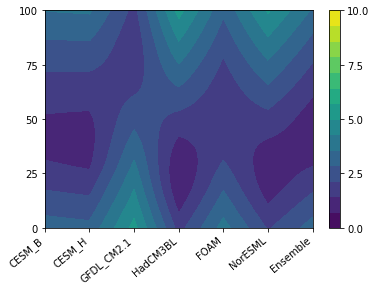

In [39]:
#SST
modelmean_SST=np.nanmean(errs_1d_SST[:,0:6,:],axis=1)
xlabels=['CESM_B','CESM_H','GFDL_CM2.1','HadCM3BL','FOAM','NorESML','Model Ensemble Mean']

fig, ax = plt.subplots()

cb=ax.contourf(modelmean_SST,levels=np.linspace(0,10,15))
ax.set_yticks([0,25,50,75,100])
ax.set_xticklabels(xlabels, rotation=40,ha='right')
#ax.set_yticklabels(ylabels)
#plt.contourf(errs_1d_SST[:,:,0])
plt.colorbar(cb,ticks=[0,2.5,5,7.5,10])
plt.savefig('perfectmodel_SSTcontour_proxy.pdf')

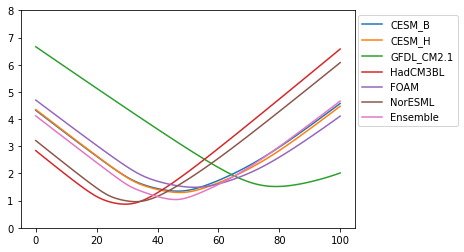

In [40]:
plt.plot(modelmean)
plt.legend(['CESM_B','CESM_H','GFDL_CM2.1','HadCM3BL','FOAM','NorESML','Model Ensemble Mean'], loc='upper right',bbox_to_anchor=(1.32, 1))
plt.ylim(0,8)
plt.savefig('perfectmodel_SATlineplot_proxy.pdf')

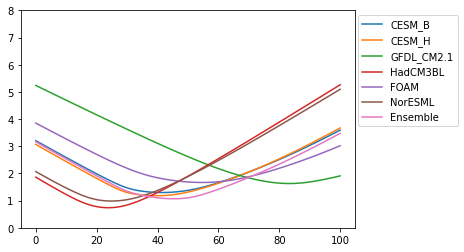

In [47]:
plt.plot(modelmean_SST)
plt.legend(['CESM_B','CESM_H','GFDL_CM2.1','HadCM3BL','FOAM','NorESML','Model Ensemble Mean'], loc='upper right',bbox_to_anchor=(1.32, 1))
plt.ylim(0,8)
plt.savefig('perfectmodel_SSTlineplot_proxy.pdf')

Estimating pCO2 drop using all gridcells for each indivdiual model temperatures as truths

For SST create an array with the coordinates spanning the Southern Ocean >45S. For SAT limit latitudes to >60S

In [49]:
diffmodel_AA_SST=diff_modelconc_SST.where(diff_modelconc_SST.latitude<-45)
diffmodel_AA_SAT=diff_modelconc.where(diff_modelconc.latitude<-60)

In [50]:
model_AA_SST=diffmodel_AA_SST.dropna(dim='latitude',how='all')
model_AA_SAT=diffmodel_AA_SAT.dropna(dim='latitude',how='all')

Plot SST and SAT gridcells to be used in the scaling

In [3]:
#making a colormap without the white
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

seismic = cm.get_cmap('seismic', 20)
seismic_colors=seismic(np.linspace(0, 1, 20))
colors = seismic_colors  # R -> G -> B
cmap_name = 'seismic_nowhite'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=20)

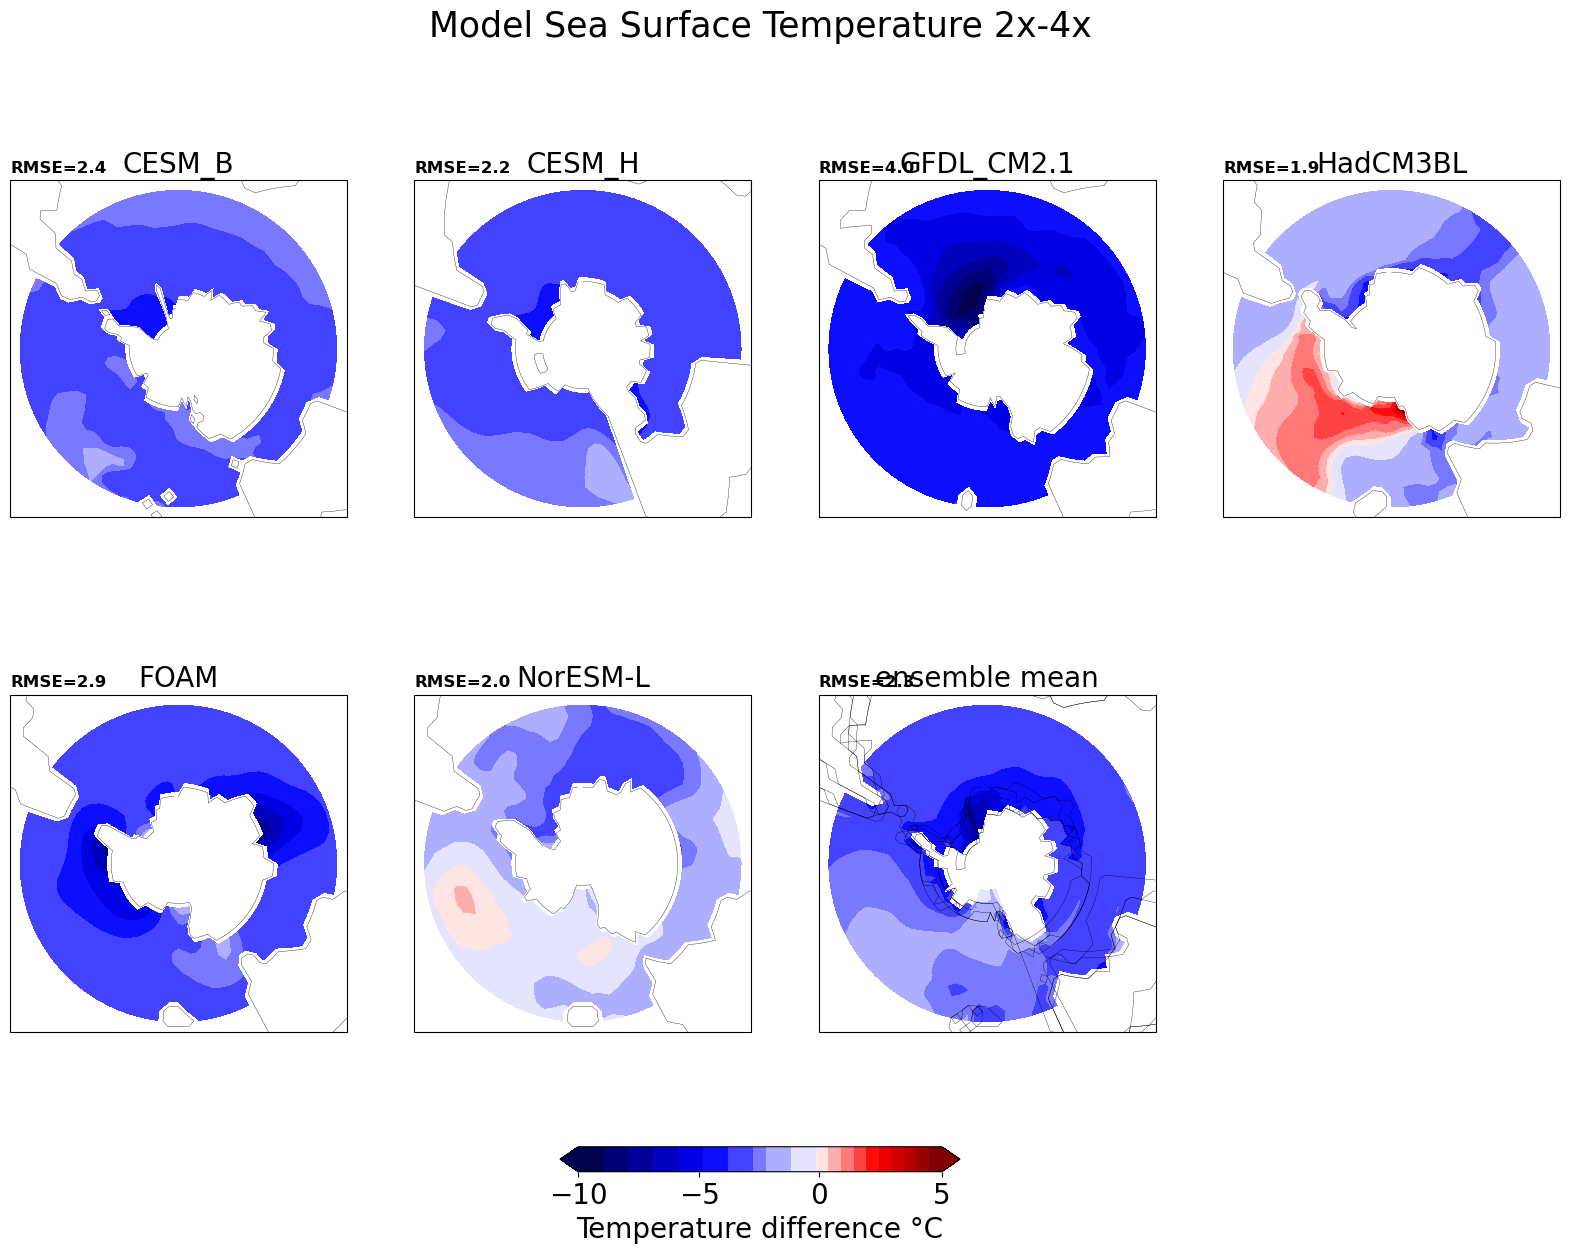

In [51]:
#SST
lats=range(0,15)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=5)

for j in range(0,len(model_AA_SST)):
    var = model_AA_SST[j][lats,lons]
    
# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=model_AA_SST.longitude)

# Make a filled contour plot
    
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap=cmap,norm=norm,levels=np.linspace(-10,5,30),extend='both')
    coast=landmask[j,:,:]*1
    if j==6:
        for k in range(0,5):
            coast_all=landmask[k,:,:]*1
            ax.contour(landmask.longitude,landmask.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
            ax.set_title("ensemble mean", fontsize=20)
    else:
        ax.contour(landmask.longitude,landmask.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
        ax.set_title(model_high[j], fontsize=20)
    ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
    ax.set_title('RMSE='+str(rms_diffSST[j]),fontweight='bold', fontsize=12,loc='left')
  
colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature difference ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model Sea Surface Temperature 2x-4x',fontsize=25)
plt.savefig('perfectmodel_SSTarea.pdf')

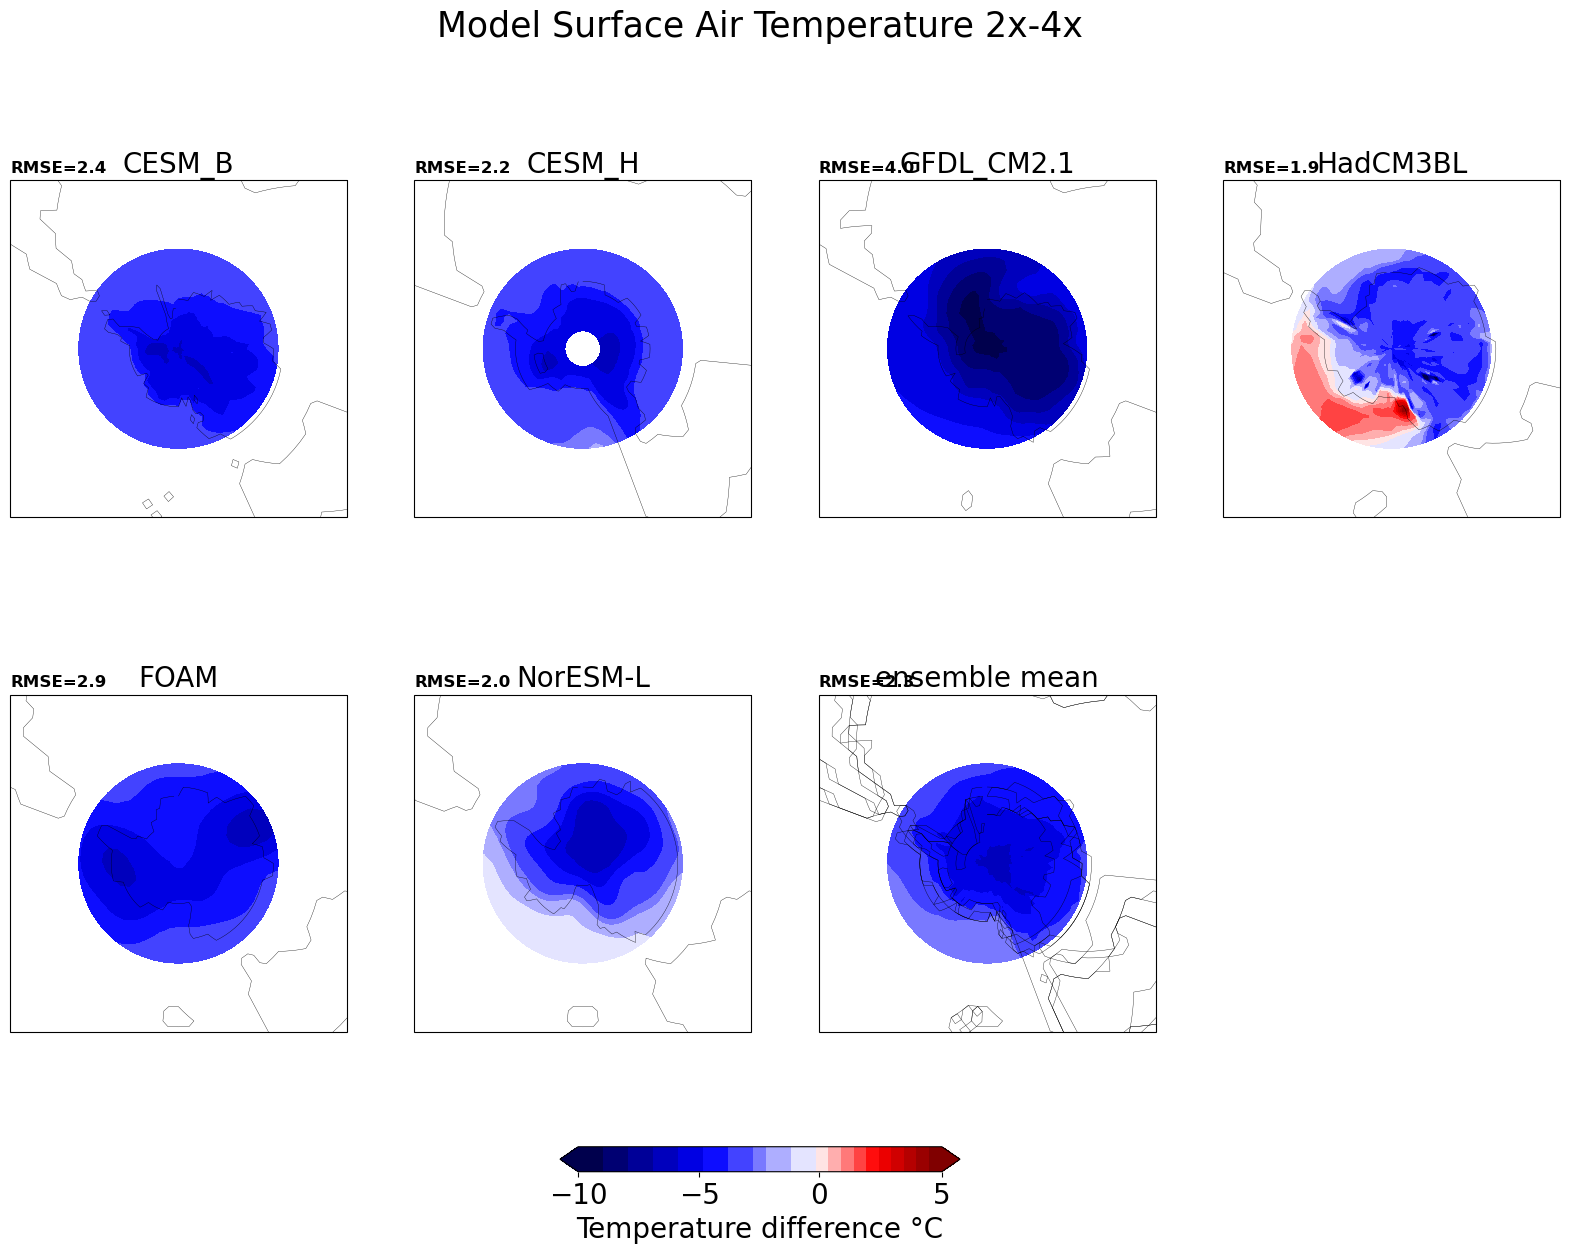

In [52]:
#SAT
lats=range(0,12)
lons=range(0,96)
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,12.5),dpi=100)
norm=mcolors.TwoSlopeNorm(vmin=-10,vcenter=0,vmax=5)

for j in range(0,len(model_AA_SAT)):
    var = model_AA_SAT[j][lats,lons]
    
# Set the axes using the specified map projection
    ax = fig.add_subplot(2, 4, j+1,projection=ccrs.SouthPolarStereo())
#add cyclic point to fill in 0 lon
    data,lon= add_cyclic_point(var,coord=model_AA_SAT.longitude)

# Make a filled contour plot
    
    cs=ax.contourf(lon,var.latitude,data, transform = ccrs.PlateCarree(),cmap=cmap,norm=norm,levels=np.linspace(-10,5,30),extend='both')
    coast=landmask[j,:,:]*1
    if j==6:
        for k in range(0,5):
            coast_all=landmask[k,:,:]*1
            ax.contour(landmask.longitude,landmask.latitude,coast_all, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
            ax.set_title("ensemble mean", fontsize=20)
    else:
        ax.contour(landmask.longitude,landmask.latitude,coast, colors='k', linestyles='-',linewidths=0.25,levels=[0.5],transform = ccrs.PlateCarree()) 
        ax.set_title(model_high[j], fontsize=20)
    ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
    ax.set_title('RMSE='+str(rms_diffSST[j]),fontweight='bold', fontsize=12,loc='left')
  


colorbar_axes = plt.gcf().add_axes([0.4, 0.05, 0.2, 0.02])
cb=plt.colorbar(cs,colorbar_axes,orientation='horizontal',shrink=0.7,pad=0.02,ticks=[-10,-5,0,5])
cb.ax.tick_params(labelsize=20)
cb.ax.set_xlabel('Temperature difference ' u"\N{DEGREE SIGN}" 'C',fontsize=20)
plt.suptitle('Model Surface Air Temperature 2x-4x',fontsize=25)
plt.savefig('perfectmodel_SATarea.pdf')

In [53]:
#can use this for both it's the same reference coordinates
array=np.empty((15,96))
southernocean=xr.DataArray(array,dims=['latitude','longitude'])
southernocean['latitude']=model_AA_SST.latitude
southernocean['longitude']=model_AA_SST.longitude

In [54]:
#can use this for both it's the same reference coordinates
array_SAT=np.empty((12,96))
southernocean_SAT=xr.DataArray(array_SAT,dims=['latitude','longitude'])
southernocean_SAT['latitude']=model_AA_SAT.latitude
southernocean_SAT['longitude']=model_AA_SAT.longitude

In [55]:
AA_SST=np.empty((15,96,7))
modelAA_SST_x2=xr.DataArray(AA_SST,dims=['latitude','longitude','nmodels'])
for i in range(0,len(southernocean['latitude'])):
    for j in range (0,len(southernocean['longitude'])):
        for h in range(0,len(diff_modelconc_SST)):
            modelAA_SST_x2[i,j,h]=(diff_modelconc_SST[h].sel(latitude=southernocean['latitude'][i],longitude=southernocean['longitude'][j],method='nearest'))

In [56]:
#SAT
AA_SAT=np.empty((12,96,7))
modelAA_SAT_x2=xr.DataArray(AA_SAT,dims=['latitude','longitude','nmodels'])
for i in range(0,len(southernocean_SAT['latitude'])):
    for j in range (0,len(southernocean_SAT['longitude'])):
        for h in range(0,len(diff_modelconc)):
            modelAA_SAT_x2[i,j,h]=(diff_modelconc[h].sel(latitude=southernocean_SAT['latitude'][i],longitude=southernocean_SAT['longitude'][j],method='nearest'))

Restructure the array into the correct numpy array format that is compatible with the analysis code

In [57]:
npAA=np.asarray(modelAA_SST_x2)
npAA_SAT=np.asarray(modelAA_SAT_x2)

In [58]:
#SST
model0=npAA[:,:,0].flatten()
model1=npAA[:,:,1].flatten()
model2=npAA[:,:,2].flatten()
model3=npAA[:,:,3].flatten()
model4=npAA[:,:,4].flatten()
model5=npAA[:,:,5].flatten()
model6=npAA[:,:,6].flatten()

#SAT
model0_SAT=npAA_SAT[:,:,0].flatten()
model1_SAT=npAA_SAT[:,:,1].flatten()
model2_SAT=npAA_SAT[:,:,2].flatten()
model3_SAT=npAA_SAT[:,:,3].flatten()
model4_SAT=npAA_SAT[:,:,4].flatten()
model5_SAT=npAA_SAT[:,:,5].flatten()
model6_SAT=npAA_SAT[:,:,6].flatten()

In [60]:
#SST
model0_2D=np.expand_dims(model0,axis=1)
model1_2D=np.expand_dims(model1,axis=1)
model2_2D=np.expand_dims(model2,axis=1)
model3_2D=np.expand_dims(model3,axis=1)
model4_2D=np.expand_dims(model4,axis=1)
model5_2D=np.expand_dims(model5,axis=1)
model6_2D=np.expand_dims(model6,axis=1)

#SAT
model0_2D_SAT=np.expand_dims(model0_SAT,axis=1)
model1_2D_SAT=np.expand_dims(model1_SAT,axis=1)
model2_2D_SAT=np.expand_dims(model2_SAT,axis=1)
model3_2D_SAT=np.expand_dims(model3_SAT,axis=1)
model4_2D_SAT=np.expand_dims(model4_SAT,axis=1)
model5_2D_SAT=np.expand_dims(model5_SAT,axis=1)
model6_2D_SAT=np.expand_dims(model6_SAT,axis=1)

In [63]:
modelAA_SST2D=np.concatenate((model0_2D,model1_2D,model2_2D,model3_2D,model4_2D,model5_2D,model6_2D),axis=1)
modelAA_SAT2D=np.concatenate((model0_2D_SAT,model1_2D_SAT,model2_2D_SAT,model3_2D_SAT,model4_2D_SAT,model5_2D_SAT,model6_2D_SAT),axis=1)

modelAA_SST=xr.DataArray(modelAA_SST2D,dims=['temp','nmodels'])
modelAA_SAT=xr.DataArray(modelAA_SAT2D,dims=['temp','nmodels'])

modelAA_SSTna=modelAA_SST.dropna(dim='temp')
modelAA_SATna=modelAA_SAT.dropna(dim='temp')

modelpd=modelAA_SSTna.to_pandas()
modelpd_SAT=modelAA_SATna.to_pandas()

modelnp=modelpd.to_numpy()
modelnp_SAT=modelpd_SAT.to_numpy()

Create a scaled array using all grid cells

In [66]:
#SST
array_SST=np.empty((101,710,7))
vect_SSTnp=xr.DataArray(array_SST,dims=['nxx','nproxies','nmodels'])
for j in range (0,len(testarray)):
    for i in range (0,710):
        for h in range(0,7):
            vect_SSTnp[j,i,h]=testarray[j]*modelnp[i,h]

In [67]:
#SAT
array_SAT=np.empty((101,960,7))
vect_SATnp=xr.DataArray(array_SAT,dims=['nxx','nproxies','nmodels'])
for j in range (0,len(testarray)):
    for i in range (0,960):
        for h in range(0,7):
            vect_SATnp[j,i,h]=testarray[j]*modelnp_SAT[i,h]

Calcualte RMSE

In [68]:
#SST
errs_1d=np.empty((101,7,7))
nanmatrix=np.empty((101,7))*np.nan
for j in range(0,len(vect_SSTnp.nmodels)):
    for i in range(0,len(vect_SSTnp.nxx)):
        for h in range(0,len(vect_SSTnp.nmodels)):
            if j==h:
                errs_1d[i,j,h]=nanmatrix[i,j]
            else:
                errs_1d[i,j,h]=SKILL(vect_SSTnp[i,:,j],modelnp[:,h],710)

In [69]:
#SAT
errs_1d_SAT=np.empty((101,7,7))
nanmatrix=np.empty((101,7))*np.nan
for j in range(0,len(vect_SATnp.nmodels)):
    for i in range(0,len(vect_SATnp.nxx)):
        for h in range(0,len(vect_SATnp.nmodels)):
            if j==h:
                errs_1d_SAT[i,j,h]=nanmatrix[i,j]
            else:
                errs_1d_SAT[i,j,h]=SKILL(vect_SATnp[i,:,j],modelnp_SAT[:,h],960)

/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


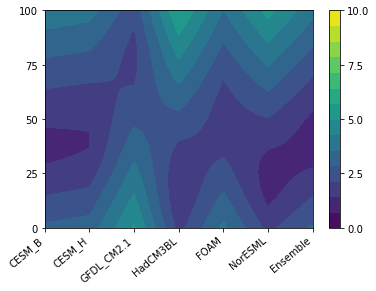

In [70]:
#SST
modelmean_SST=np.nanmean(errs_1d[:,0:6,:],axis=1)
xlabels=['CESM_B','CESM_H','GFDL_CM2.1','HadCM3BL','FOAM','NorESML','Model Ensemble Mean']
#ylabels=[0,0.5,1,1.5,2]

fig, ax = plt.subplots()

cb=ax.contourf(modelmean_SST,levels=np.linspace(0,10,15))
ax.set_yticks([0,25,50,75,100])
ax.set_xticklabels(xlabels, rotation=40,ha='right')
#ax.set_yticklabels(ylabels)
#plt.contourf(errs_1d_SST[:,:,0])
plt.colorbar(cb,ticks=[0,2.5,5,7.5,10])
plt.savefig('perfectmodel_SSTcontour.pdf')

/homes/etibbett/.conda/envs/aoes/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


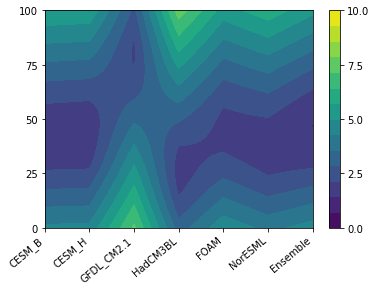

In [71]:
#SAT
modelmean_SAT=np.nanmean(errs_1d_SAT[:,0:6,:],axis=1)
xlabels=['CESM_B','CESM_H','GFDL_CM2.1','HadCM3BL','FOAM','NorESML','Model Ensemble Mean']
#ylabels=[0,0.5,1,1.5,2]

fig, ax = plt.subplots()

cb=ax.contourf(modelmean_SAT,levels=np.linspace(0,10,15))
ax.set_yticks([0,25,50,75,100])
ax.set_xticklabels(xlabels, rotation=40,ha='right')
#ax.set_yticklabels(ylabels)
#plt.contourf(errs_1d_SST[:,:,0])
plt.colorbar(cb,ticks=[0,2.5,5,7.5,10])
plt.savefig('perfectmodel_SATcontour.pdf')

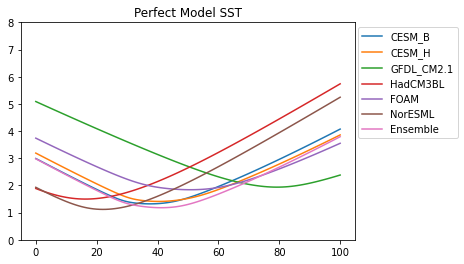

In [72]:
plt.plot(modelmean_SST)
plt.legend(['CESM_B','CESM_H','GFDL_CM2.1','HadCM3BL','FOAM','NorESML','Model Ensemble Mean'], loc='upper right',bbox_to_anchor=(1.32, 1))
plt.ylim(0,8)
plt.title('Perfect Model SST')
plt.savefig('perfectmodel_SSTlineplot.pdf')

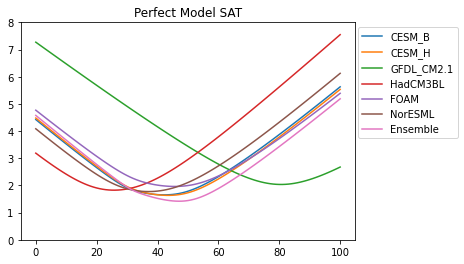

In [73]:
plt.plot(modelmean_SAT)
plt.legend(['CESM_B','CESM_H','GFDL_CM2.1','HadCM3BL','FOAM','NorESML','Model Ensemble Mean'], loc='upper right',bbox_to_anchor=(1.32, 1))
plt.ylim(0,8)
plt.title('Perfect Model SAT')
plt.savefig('perfectmodel_SATlineplot.pdf')